# **White Blood Cell Image Classification**  
**Comparative Analysis of Models for White Blood Cell Image Classification**

Alexine & Julie <3



White blood cells, or leukocytes, are essential components of the immune system, responsible for defending the body against infections and diseases. Among them, various subtypes – lymphocytes, monocytes, neutrophils, and eosinophils – perform distinct functions in the immune response. Accurate classification of these cells is crucial for diagnosing various blood-related conditions, including infections, inflammatory diseases, and certain cancers. However, this task, when performed manually, is often complex, time-consuming, and prone to human error.

This project aims to automate this classification process using machine learning techniques to improve both the speed and accuracy of diagnoses. Three primary models were tested: a Random Forest model, a custom Convolutional Neural Network (CNN), and a fine-tuned version of VGG16. These models were evaluated to determine which one delivers the best performance for white blood cell image classification.

In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
import cv2
import numpy as np
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import collections
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.applications import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. DONNÉES

The data used for this project comes from the Kaggle platform and consists of 12,500 images of white blood cells. You can find the dataset here : https://www.kaggle.com/datasets/paultimothymooney/blood-cells . These images are labeled, with each cell pre-classified into one of four main categories:  

- **Lymphocyte**: Small with a dark, round nucleus and minimal visible cytoplasm. It plays a crucial role in immunity by specifically targeting pathogens through adaptive immune responses.  
- **Monocyte**: Large with a bean-shaped nucleus. This cell transforms into a macrophage to engulf and eliminate pathogens and dead cells.  
- **Eosinophil**: Bilobed nucleus with reddish granules. It is involved in defending against parasites and allergic reactions by releasing inflammatory substances.  
- **Neutrophil**: Multilobed nucleus (typically 3-5 lobes) with granular cytoplasm. It serves as the body's first line of defense, destroying bacteria through phagocytosis.  

Each cell type exhibits distinct visual characteristics, enabling precise analysis by machine learning models.  

**Note**: Monocytes and neutrophils share similarities in their large size and granular cytoplasm, which can lead to confusion in classification models. This morphological similarity is a key challenge to address for improving the accuracy of cell recognition models.  

As a first step, it is necessary to import and visualize the data.

## 1.1 importation et visualisation

In [2]:
#  Path to the TRAIN folder in dataset2-master
train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/'

classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# initializing lists to store images and labels
train_images = []
train_labels = []

# iterate through each class folder
for cell_type in classes:
    cell_dir = os.path.join(train_dir, cell_type)
    for img_file in os.listdir(cell_dir):
        img_path = os.path.join(cell_dir, img_file)
        img = load_img(img_path, target_size=(128, 128))
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # pixel normalization

        train_images.append(img_array)
        train_labels.append(cell_type)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print(f"Nombre d'images chargées pour l'entraînement : {train_images.shape[0]}")
print(f"Dimensions des images : {train_images.shape[1:]}")

Nombre d'images chargées pour l'entraînement : 9957
Dimensions des images : (128, 128, 3)


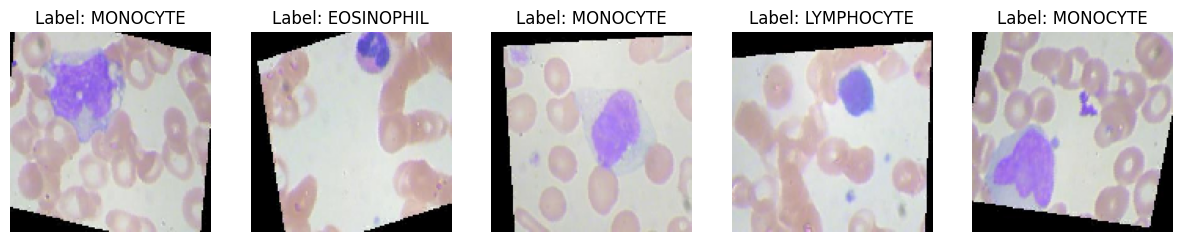

In [3]:
# encode text labels into numeric labels for display
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(train_labels)

# show 5 random images
random_indices = random.sample(range(train_images.shape[0]), 5)
plt.figure(figsize=(15, 5))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(train_images[idx])
    plt.title(f"Label: {encoder.inverse_transform([encoded_labels[idx]])[0]}")
    plt.axis('off')
plt.show()

The images are not properly sized, which could impact the quality of the analysis. Therefore, it is necessary to preprocess them to standardize their dimensions before proceeding with model training.

In [4]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)

print(train_labels_encoded[:10])

[0 0 0 0 0 0 0 0 0 0]


In [5]:
print(train_labels[:10])

import collections
print(collections.Counter(train_labels))

['EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL'
 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL' 'EOSINOPHIL']
Counter({'NEUTROPHIL': 2499, 'EOSINOPHIL': 2497, 'LYMPHOCYTE': 2483, 'MONOCYTE': 2478})



Here, we can see the representation of the different cell classes, with a balanced number for each type. This indicates a relatively uniform distribution across the dataset.

## 1.2 data augmentation

To resize the images and normalize the regions of interest, a series of functions is used. The findEdges(image) function first identifies the main edges of the image by reducing noise and then applying edge detection. Next, getImgContours(edged) sorts these contours by size, and extractBoundingBoxes(contours, image) generates bounding boxes around each relevant contour, allowing significant regions in the image to be isolated and resized for improved classification.

In [6]:
def findEdges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    gray = cv2.bilateralFilter(gray, 9, 75, 75)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

def getImgContours(edged):
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

def extractBoundingBoxes(contours, image):
    boxes = []
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        points = cv2.boxPoints(rect)  
        points = np.array(points, dtype="int")
        
        top_left, top_right, bottom_right, bottom_left = points
        if dist.euclidean(top_left, bottom_left) > 0 and dist.euclidean(top_left, top_right) > 0:
            boxes.append(points)
    return boxes

In [7]:
def previewImageTransformations(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])

    plt.imshow(img)
    plt.title('Original Image')
    plt.show()

    masked_img = cv2.inRange(img, (80, 80, 180), (180, 170, 245))
    
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_large = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(masked_img, kernel_small, iterations=2)
    masked_img = cv2.dilate(eroded, kernel_large, iterations=5)

    plt.imshow(masked_img, cmap='gray')
    plt.title('Thresholded and Cleaned Image')
    plt.show()

    edges = findEdges(masked_img)
    contours = getImgContours(edges)
    boxes = extractBoundingBoxes(contours, img.copy())

    if boxes:
        largest_box = boxes[-1]
        max_x, min_x = int(max(largest_box[:, 0])), int(min(largest_box[:, 0]))
        max_y, min_y = int(max(largest_box[:, 1])), int(min(largest_box[:, 1]))

        mask = np.zeros_like(img)
        cv2.drawContours(mask, contours, len(contours) - 1, (255, 255, 255), -1)
        img[mask == 0] = 0

        plt.imshow(img)
        plt.title('Masked Image with Detected Contours')
        plt.show()

        img_with_contours = img.copy()
        cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 1)
        plt.imshow(img_with_contours)
        plt.title('Image with Contours Highlighted')
        plt.show()

        cropped_img = img[min_y:max_y, min_x:max_x]
        
        plt.imshow(cropped_img)
        plt.title('Cropped Image')
        plt.show()


we start by testing with a sample before applying it to all our data.

In [8]:
def plotRandomImageBeforeAndAfter(folder_path):
    if not os.path.isdir(folder_path):
        print(f"folder path doesnt exist : {folder_path}")
        return
    
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not image_files:
        print("no images in the folder.")
        return
    
    random_image_path = os.path.join(folder_path, random.choice(image_files))

    original_img = cv2.imread(random_image_path)
    if original_img is None:
        print(f"Unable to load the image : {random_image_path}")
        return
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    img = original_img_rgb.copy()
    img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])

    masked_img = cv2.inRange(img, (80, 80, 180), (180, 170, 245))
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_large = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(masked_img, kernel_small, iterations=2)
    masked_img = cv2.dilate(eroded, kernel_large, iterations=5)

    edges = findEdges(masked_img)
    contours = getImgContours(edges)
    boxes = extractBoundingBoxes(contours, img.copy())

    if boxes:
        largest_box = boxes[-1]
        max_x, min_x = int(max(largest_box[:, 0])), int(min(largest_box[:, 0]))
        max_y, min_y = int(max(largest_box[:, 1])), int(min(largest_box[:, 1]))

        mask = np.zeros_like(img)
        cv2.drawContours(mask, contours, len(contours) - 1, (255, 255, 255), -1)
        img[mask == 0] = 0
        cropped_img = img[min_y:max_y, min_x:max_x]
        final_img = cropped_img if cropped_img.size != 0 else img
    else:
        final_img = img

    plt.subplot(1, 2, 2)
    plt.imshow(final_img)
    plt.title("Processed Image")
    plt.axis("off")
    plt.show()


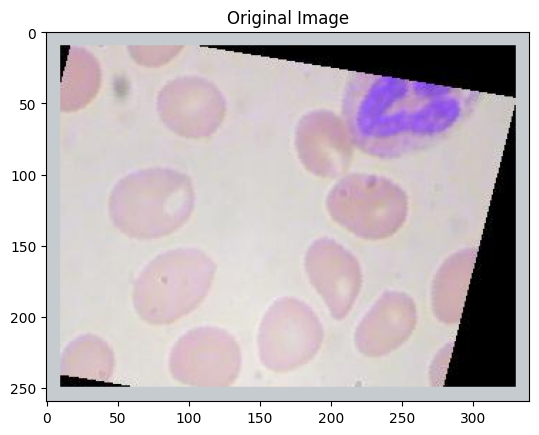

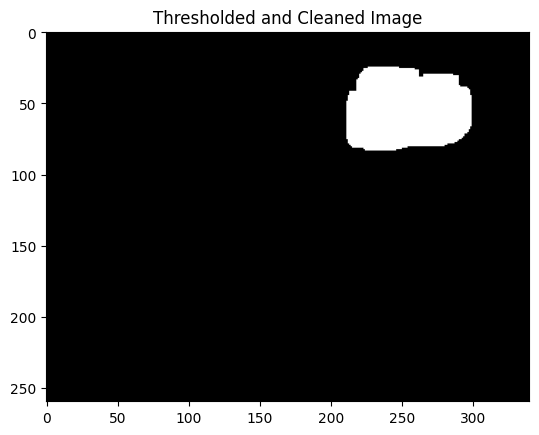

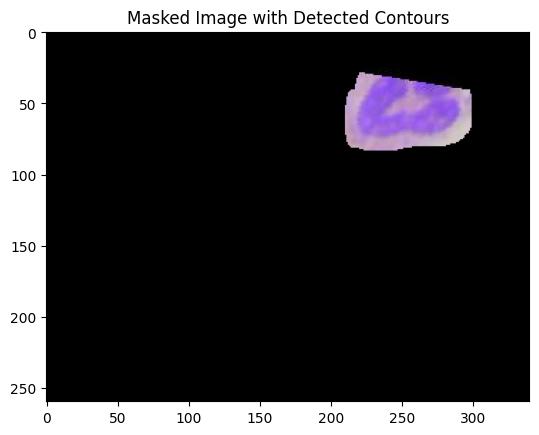

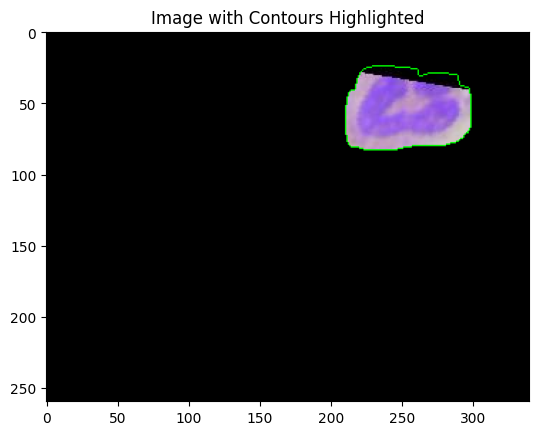

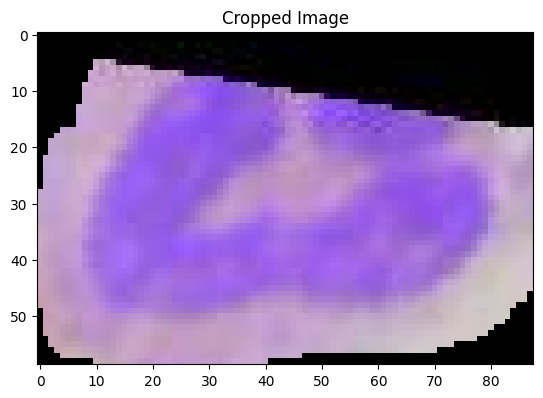

In [9]:
train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL'

image_path = os.path.join(train_dir, random.choice(os.listdir(train_dir)))

previewImageTransformations(image_path)



We can now proceed with data augmentation. It is preferable to create a new folder to store our processed images.

In [10]:
def overwriteImagesInNewFolders(folder_path):
    processed_images = os.path.join(os.getcwd(), "processed_images")
    
    # create directories in "processed_images"
    cell_types = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
    cell_paths = {cell_type: os.path.join(processed_images, cell_type) for cell_type in cell_types}
    
    for path in cell_paths.values():
        os.makedirs(path, exist_ok=True)

    # Process each cell type folder in the main directory
    for cell_type in cell_types:
        cell_folder_path = os.path.join(folder_path, "TRAIN", cell_type)
        
        if not os.path.isdir(cell_folder_path):
            print(f"Dossier non trouvé : {cell_folder_path}")
            continue

        # Iterate over each image in the cell type folder
        for filename in os.listdir(cell_folder_path):
            image_path = os.path.join(cell_folder_path, filename)
            
            if not (filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png')):
                continue
            
            # Load and add a border to the original image
            img = cv2.imread(image_path)
            if img is None:
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.copyMakeBorder(img, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[198, 203, 208])
            
            # Thresholding and cleaning
            masked_img = cv2.inRange(img, (80, 80, 180), (180, 170, 245))
            kernel_small = np.ones((3, 3), np.uint8)
            kernel_large = np.ones((5, 5), np.uint8)
            eroded = cv2.erode(masked_img, kernel_small, iterations=2)
            masked_img = cv2.dilate(eroded, kernel_large, iterations=5)

            # Edge detection and extraction
            edges = findEdges(masked_img)
            contours = getImgContours(edges)
            boxes = extractBoundingBoxes(contours, img.copy())

            # If contours are found, get the largest bounding box and crop
            if boxes:
                largest_box = boxes[-1]
                max_x, min_x = int(max(largest_box[:, 0])), int(min(largest_box[:, 0]))
                max_y, min_y = int(max(largest_box[:, 1])), int(min(largest_box[:, 1]))

                mask = np.zeros_like(img)
                cv2.drawContours(mask, contours, len(contours) - 1, (255, 255, 255), -1)
                img[mask == 0] = 0

                # Crop the image based on the bounding box
                cropped_img = img[min_y:max_y, min_x:max_x]
                
                final_img = cropped_img if cropped_img.size != 0 else img
            else:
                final_img = img  

            save_image_path = os.path.join(cell_paths[cell_type], filename)
            cv2.imwrite(save_image_path, cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR))
    
    print("All images have been processed and saved in the 'processed_images' folder.")


    
overwriteImagesInNewFolders('/kaggle/input/blood-cells/dataset2-master/dataset2-master/images')


Toutes les images ont été traitées et enregistrées dans le dossier 'processed_images'.


To ensure that the processing was successful, we display one cell from each folder.

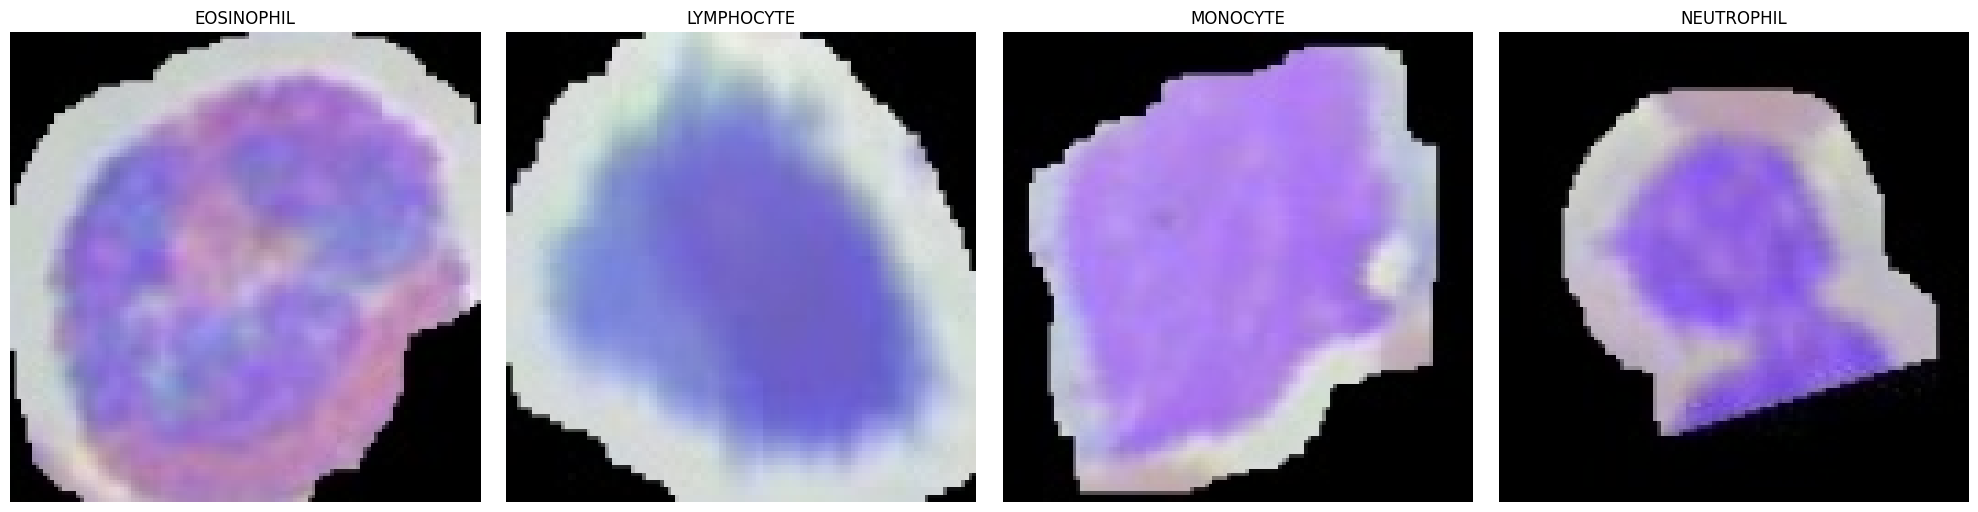

In [11]:
# Chemin vers les images traitées
processed_images_dir = os.path.join(os.getcwd(), "processed_images")
list_cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

# Afficher une image traitée par type de cellule avec un recadrage
fig, axes = plt.subplots(1, len(list_cells), figsize=(20, 5))

for i, cell_type in enumerate(list_cells):
    path = os.path.join(processed_images_dir, cell_type)
    files = os.listdir(path)
    
    # Vérifier qu'il y a au moins un fichier dans le dossier
    if files:
        image_path = os.path.join(path, files[0])
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Redimensionner à une taille fixe pour améliorer la visibilité (optionnel)
        display_img = cv2.resize(image_rgb, (128, 128), interpolation=cv2.INTER_AREA)
        
        axes[i].imshow(display_img)
        axes[i].set_title(cell_type)
        axes[i].axis("off")
    else:
        axes[i].text(0.5, 0.5, "Aucune image", ha="center", va="center")
        axes[i].set_title(cell_type)
        axes[i].axis("off")

plt.tight_layout()
plt.show()


We can see that our cells have been successfully cropped. This will make the classification process easier for our models.

We split the data into two sets, with 80% for training and 20% for validation, to prepare the model for effective classification and ensure good class representation. Next, the labels are encoded to represent the 4 cell classes, ensuring compatibility with the model, and the dimensions of each set are confirmed to verify their proper structuring.

In [12]:
processed_images_dir = "processed_images"  # Mettre à jour si nécessaire
list_cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]

images = []
labels = []

# Définir une taille commune pour toutes les images
target_size = (128, 128)

# Charger les images et assigner des labels basés sur les noms des dossiers
for label, cell_type in enumerate(list_cells):
    path = os.path.join(processed_images_dir, cell_type)
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        img = cv2.imread(image_path)
        
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en format RGB
            img = cv2.resize(img, target_size)  # Redimensionner à 128x128
            images.append(img)
            labels.append(label)  # Label basé sur le dossier

# Convertir les listes en tableaux numpy
images = np.array(images)
labels = np.array(labels)

In [13]:
# Séparer le jeu de données en 80% données d'entrainement et 20% données de validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Encodage one-shot
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

print(f"Training data dimensions: {X_train.shape}")
print(f"Training labels dimensions: {y_train.shape}")
print(f"Validation data dimensions: {X_val.shape}")
print(f"Validation labels dimensions: {y_val.shape}")

Training data dimensions: (7965, 128, 128, 3)
Training labels dimensions: (7965, 4)
Validation data dimensions: (1992, 128, 128, 3)
Validation labels dimensions: (1992, 4)


# 2 METHODS

We used three models to tackle this cell classification task:

- **Random Forest**: Chosen for its ability to capture patterns and relationships within the data, providing a robust initial baseline.  
- **Fine-tuned VGG16**: Selected to leverage a pre-trained model on a large image dataset, capable of capturing complex visual features specific to cells while being tailored to our dataset.  
- **Custom CNN**: Developed to adapt to the specifics of our dataset, with an architecture optimized to efficiently identify the visual features of cells.  

Each model offers a different approach, allowing us to explore various methods to maximize classification accuracy.

## 2.1 RANDOM FOREST

We configured our Random Forest model with 100 trees (`n_estimators=100`) and a fixed random state (`random_state=42`) to ensure the reproducibility of the results.

### Initialisation et entrainement du modèle

In [14]:
# Aplatir les images pour les rendre compatibles avec Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_val_rf = X_val.reshape(X_val.shape[0], -1)        

# Initialiser et entraîner le modèle à 100 arbres
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train)

RandomForestClassifier(random_state=42)

### Model Evaluation

Next, we evaluate our model by making predictions on the validation set. We choose to focus on two types of evaluation:  
- The classification report  
- The confusion matrix  

In [15]:
# Évaluer le modèle
accuracy = rf_model.score(X_val_rf, y_val)
print(f"Accuracy du modèle Random Forest: {accuracy:.2f}")

Accuracy du modèle Random Forest: 0.79


In [16]:
# Prédire sur l'ensemble de validation
y_pred_rf = rf_model.predict(X_val_rf)

# Évaluer les performances
accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy du Random Forest : {accuracy:.2f}")

# Rapport de classification
print("Rapport de classification :")
print(classification_report(y_val, y_pred_rf, target_names=encoder.classes_, zero_division=1))

Accuracy du Random Forest : 0.79
Rapport de classification :
              precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.66      0.79       509
  LYMPHOCYTE       0.99      0.96      0.97       506
    MONOCYTE       0.98      0.90      0.94       488
  NEUTROPHIL       0.96      0.63      0.76       489

   micro avg       0.98      0.79      0.87      1992
   macro avg       0.97      0.79      0.87      1992
weighted avg       0.97      0.79      0.87      1992
 samples avg       0.98      0.79      0.79      1992



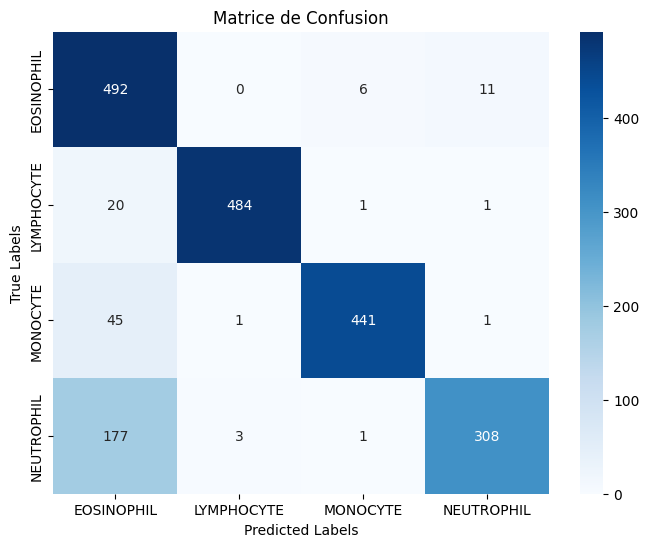

In [17]:
# Convertir en labels simples
if len(y_val.shape) > 1 and y_val.shape[1] > 1: 
    y_val = np.argmax(y_val, axis=1)
if len(y_pred_rf.shape) > 1 and y_pred_rf.shape[1] > 1:
    y_pred_rf = np.argmax(y_pred_rf, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matrice de Confusion")
plt.show()

The classification report shows good overall accuracy, especially for the lymphocyte and monocyte classes, with high F1 scores. However, the eosinophil and neutrophil classes have lower recall scores (0.66 and 0.63, respectively), indicating that the model struggles to identify them correctly. The model achieves satisfactory overall accuracy and is relatively fast, but it fails to capture the full complexity of our data, particularly for these two classes.

Note: We trained our Random Forest model on images without extracting specific features, but we could have achieved better results by extracting features such as color and/or granularity and training our model on those.

## 2.2 VGG16

We integrated the **VGG16** model to enhance our approach to cell classification. This deep convolutional model is well-suited for extracting complex features in images due to its robust pre-trained architecture (though in our case, the weights were initialized from scratch). Here are the adaptation steps:

1. **Architecture Configuration**:  
   We loaded VGG16 without its top layer (`include_top=False`) and adjusted the input image size to `(128, 128, 3)`. The VGG16 layers were **frozen** to prevent adjustment during training, allowing the model to leverage general visual features extracted by VGG16.

2. **Addition of Custom Layers**:  
   We added several fully connected layers to enable the model to focus on the specific characteristics of cell images. This included normalization layers, dropout layers to reduce overfitting, and dense layers with the `relu` activation function.

3. **Optimization Setup**:  
   The model was compiled with the `adam` optimizer, and the **`categorical_crossentropy` loss function** was used for classifying the four classes.

4. **Learning Rate Reduction**:  
   A `ReduceLROnPlateau` callback was defined to dynamically adjust the learning rate based on validation performance, enabling more stable convergence.

Finally, the model was trained using the training and validation datasets over 30 epochs with a batch size of 32, ensuring optimization tailored to the specifics of our dataset.

### Initialisation du modèle

In [18]:
if len(y_train.shape) > 1:
    y_train_fixed = np.argmax(y_train, axis=-1) 
else:
    y_train_fixed = y_train

if len(y_val.shape) > 1:
    y_val_fixed = np.argmax(y_val, axis=-1) 
else:
    y_val_fixed = y_val

# one-hot encoding
y_train_one_hot = to_categorical(y_train_fixed, num_classes=4)
y_val_one_hot = to_categorical(y_val_fixed, num_classes=4)

In [20]:
# IF U USE THIS NOTEBOOK IN KAGGLE,  MAKE SURE TO TURN ON THE INTERNET MODE

# Loading the pre-trained VGG16 model
vgg16_model = VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(128, 128, 3)
)

# Freeze all layers of VGG16
for layer in vgg16_model.layers:
    layer.trainable = False

# Model construction
input_layer = Input(shape=(128, 128, 3))
x = vgg16_model(input_layer)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# model compilation
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

# callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=2, 
    factor=0.3, 
    min_lr=1e-6, 
    verbose=1
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Model Training

In [21]:
history = model.fit(
    X_train,
    y_train_one_hot, 
    validation_data=(X_val, y_val_one_hot), 
    batch_size=32, 
    epochs=15, 
    callbacks=[early_stopping, learning_rate_reduction]
)

Epoch 1/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 946s 4s/step - accuracy: 0.4318 - loss: 1.3174 - val_accuracy: 0.7676 - val_loss: 0.5643 - learning_rate: 0.0010
Epoch 2/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 940s 4s/step - accuracy: 0.6740 - loss: 0.7506 - val_accuracy: 0.8107 - val_loss: 0.4254 - learning_rate: 0.0010
Epoch 3/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 985s 4s/step - accuracy: 0.7656 - loss: 0.5686 - val_accuracy: 0.8394 - val_loss: 0.3615 - learning_rate: 0.0010
Epoch 4/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 951s 4s/step - accuracy: 0.8123 - loss: 0.4661 - val_accuracy: 0.8635 - val_loss: 0.3229 - learning_rate: 0.0010
Epoch 5/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 941s 4s/step - accuracy: 0.8369 - loss: 0.4153 - val_accuracy: 0.8840 - val_loss: 0.2981 - learning_rate: 0.0010
Epoch 6/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 923s 4s/step - accuracy: 0.8438 - loss: 0.3720 - val_accuracy: 0.8936 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 7/15
249/249 ━━━━━━━━━━━━━━━━━━━━ 918s 4s/step - accuracy: 0.8601 - loss: 0.

### Model Evaluation

We proceed with the evaluation of the model by plotting the accuracy and loss curves for both training and validation, allowing us to track convergence over the epochs. We assess the model's final performance on the validation set by displaying the obtained loss and accuracy. Finally, we present the confusion matrix generated by the model.

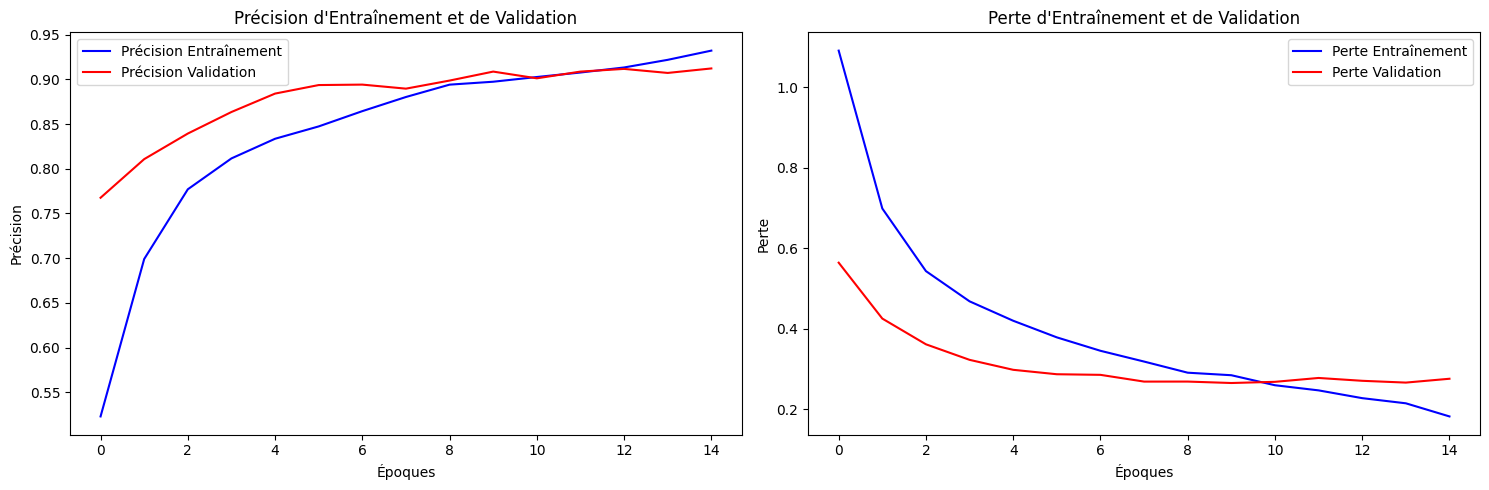

In [22]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(epochs, train_accuracy, 'b', label='Training Accuracy')
axes[0].plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, train_loss, 'b', label='Training Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_title('Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


In [23]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val_one_hot)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9008 - loss: 0.2811
Loss sur validation : 0.2652987837791443
Accuracy sur validation : 0.9086345434188843


In [24]:
# Get predictions for the validation data
y_pred = model.predict(X_val)

# Convert predicted values to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels (one-hot encoded) to class labels
y_true = np.argmax(y_val_one_hot, axis=1)

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"])

print(report)

63/63 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step
              precision    recall  f1-score   support

  EOSINOPHIL       0.87      0.80      0.84       509
  LYMPHOCYTE       0.99      0.98      0.99       506
    MONOCYTE       0.94      0.98      0.96       488
  NEUTROPHIL       0.83      0.87      0.85       489

    accuracy                           0.91      1992
   macro avg       0.91      0.91      0.91      1992
weighted avg       0.91      0.91      0.91      1992



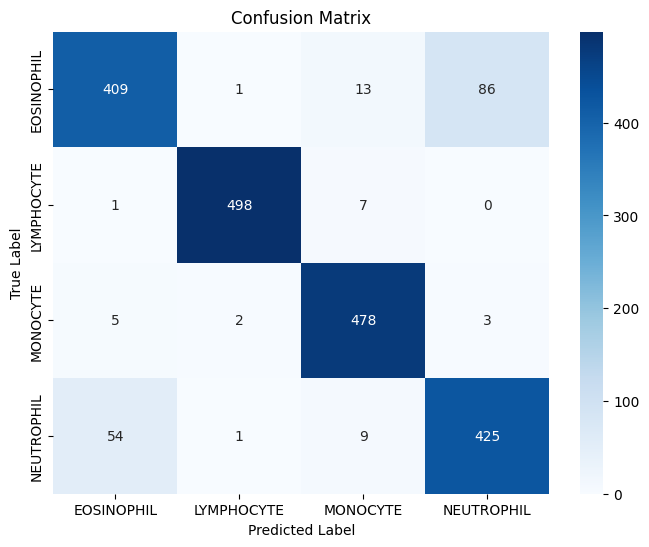

In [25]:
cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues", 
    xticklabels=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], 
    yticklabels=['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
)
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


The training and validation accuracy and loss demonstrate stable convergence. The classification report indicates acceptable performance with an overall accuracy of 91%, although the F1 scores for the eosinophil (0.84) and neutrophil (0.85) classes are lower, highlighting difficulties in identifying these classes. The confusion matrix confirms these weaknesses, showing frequent misclassifications for these two classes, which negatively impacts the model's overall performance.

## 2.3 CUSTOM CNN

We designed a **custom Convolutional Neural Network (CNN)** to enhance our approach to blood cell classification. This model is specifically tailored to extract relevant features from the images, leveraging an architecture optimized for our dataset. Here are the steps involved in designing and configuring our model:

1. **Architecture Configuration**:  
   We constructed a CNN with several convolutional layers using standard `(3, 3)` kernels and the `relu` activation function. The input image size was set to `(128, 128, 3)` to match our preprocessed data. Batch normalization layers and max pooling were integrated to improve convergence and reduce overfitting.

2. **Optimization Setup**:  
   The model was compiled with the `SGD` (Stochastic Gradient Descent) optimizer, and the **`categorical_crossentropy` loss function** was employed for classifying the four blood cell types.

3. **Model Training**:  
   The model was trained on the training set and validated on the validation set over a total of 10 epochs, using an appropriate batch size to optimize learning efficiency.

### Initialisation du modèle

In [26]:
model = keras.models.Sequential([
    # first convolutional layer
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', input_shape=(128, 128, 3), padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # second convolutional layer
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # third
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    # fourth
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # fith
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    # fully connected layers
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)

In [28]:
if len(y_train.shape) > 1:
    y_train_fixed = np.argmax(y_train, axis=-1) 
else:
    y_train_fixed = y_train

if len(y_val.shape) > 1:
    y_val_fixed = np.argmax(y_val, axis=-1) 
else:
    y_val_fixed = y_val

# one-hot encoding
y_train_one_hot = to_categorical(y_train_fixed, num_classes=4)
y_val_one_hot = to_categorical(y_val_fixed, num_classes=4)

In [29]:
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"First label in y_train: {y_train[0]}")


y_train shape: (7965, 4)
y_val shape: (1992,)
First label in y_train: [1. 0. 0. 0.]


In [30]:
# Compilation du modèle
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    33,555,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,755,076 (140.21 MB)

 Trainable params: 36,752,644 (140.20 MB)

 Non-trainable params: 2,432 (9.50 KB)

### Entrainement du modèle

In [31]:
history = model.fit(
    X_train,
    y_train_one_hot, 
    validation_data=(X_val, y_val_one_hot), 
    epochs=10,
    verbose=1
)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1219s 5s/step - accuracy: 0.4789 - loss: 1.6380 - val_accuracy: 0.3007 - val_loss: 1.5566
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1229s 5s/step - accuracy: 0.7561 - loss: 0.6260 - val_accuracy: 0.7535 - val_loss: 0.6419
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1301s 5s/step - accuracy: 0.8399 - loss: 0.4090 - val_accuracy: 0.8444 - val_loss: 0.3668
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1217s 5s/step - accuracy: 0.8780 - loss: 0.3178 - val_accuracy: 0.9237 - val_loss: 0.2047
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1221s 5s/step - accuracy: 0.9118 - loss: 0.2453 - val_accuracy: 0.9367 - val_loss: 0.1913
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1229s 5s/step - accuracy: 0.9175 - loss: 0.2100 - val_accuracy: 0.9157 - val_loss: 0.2315
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1240s 5s/step - accuracy: 0.9241 - loss: 0.1932 - val_accuracy: 0.9127 - val_loss: 0.2535
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 1218s 5s/step - accuracy: 0.9482 - loss: 0.1457 - 

### Model Evaluation

As with the previous model, we evaluate our model by focusing on the accuracy and loss curves for training and validation. Finally, we display the confusion matrix generated by our model.

In [34]:
val_loss, val_accuracy = model.evaluate(X_val, y_val_one_hot, verbose=1)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.9665 - loss: 0.1026
Validation Loss: 0.10620816797018051
Validation Accuracy: 0.9648594260215759


In [35]:
# Predictions on the validation set
predictions = model.predict(X_val)
pred_indices = np.argmax(predictions, axis=1)

# True labels
y_true = np.argmax(y_val_one_hot, axis=1)

# Map class indices to labels
labels_map = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}

# Convert indices to labels
pred_labels = [labels_map[k] for k in pred_indices]
true_labels = [labels_map[k] for k in y_true]

# Classification report
print(classification_report(true_labels, pred_labels))

# Overall accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print("Accuracy of the Model: {:.1f}%".format(accuracy * 100))


63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step
              precision    recall  f1-score   support

  EOSINOPHIL       0.94      0.94      0.94       509
  LYMPHOCYTE       0.99      0.99      0.99       506
    MONOCYTE       0.98      0.99      0.99       488
  NEUTROPHIL       0.94      0.94      0.94       489

    accuracy                           0.96      1992
   macro avg       0.96      0.96      0.96      1992
weighted avg       0.96      0.96      0.96      1992

Accuracy of the Model: 96.5%


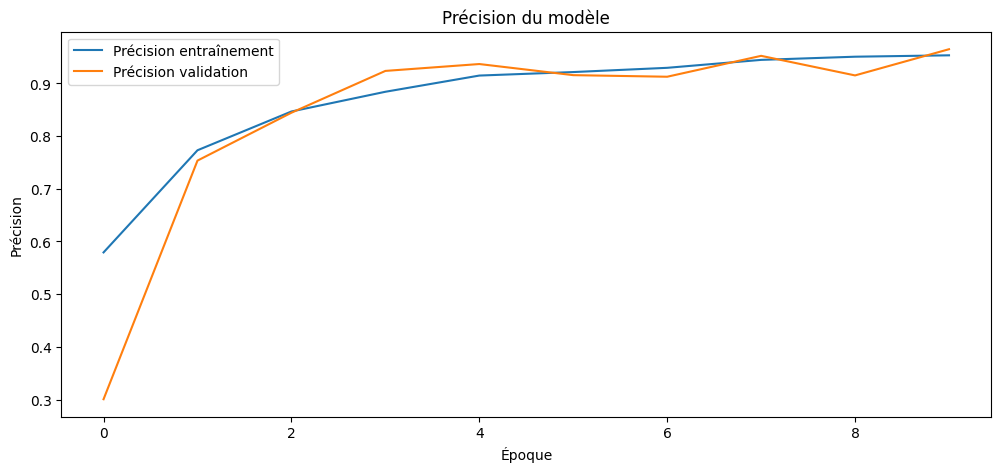

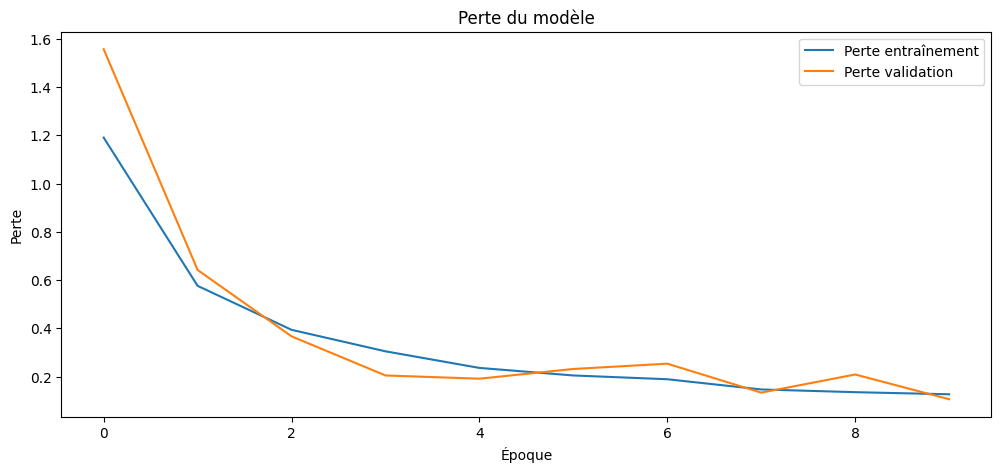

In [39]:
# Accuracy curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss curve
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


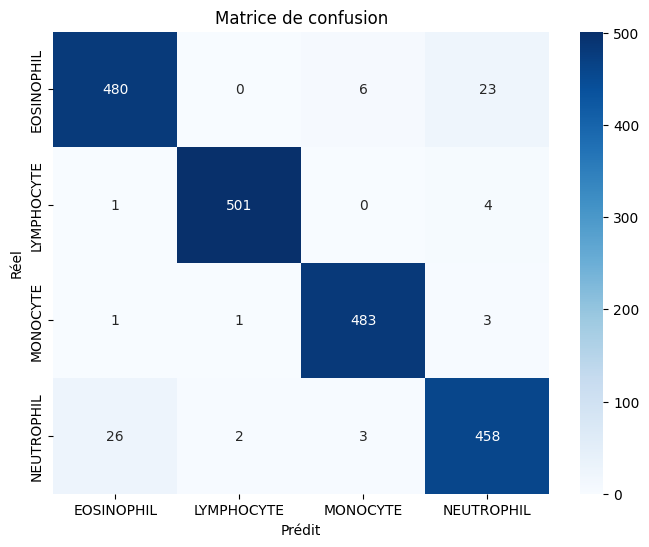

In [40]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=list(labels_map.values()))

# Display
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels_map.values()),
            yticklabels=list(labels_map.values()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The training and validation accuracy and loss demonstrate stable convergence, close to ideal values, indicating that the model generalizes well without overfitting. The classification report confirms this performance with a high overall accuracy, including excellent F1 scores for the lymphocyte and monocyte classes (0.99). Unlike the previous model, the eosinophil and neutrophil classes achieve strong recall scores (0.94 and 0.94, respectively), reflecting a significant improvement in their detection.

# 3 MODELS EVALUATION


After conducting a qualitative evaluation for each model, we perform a quantitative evaluation to determine which model offers the best performance. This comparative analysis will allow us to select the most suitable model for our classification task.

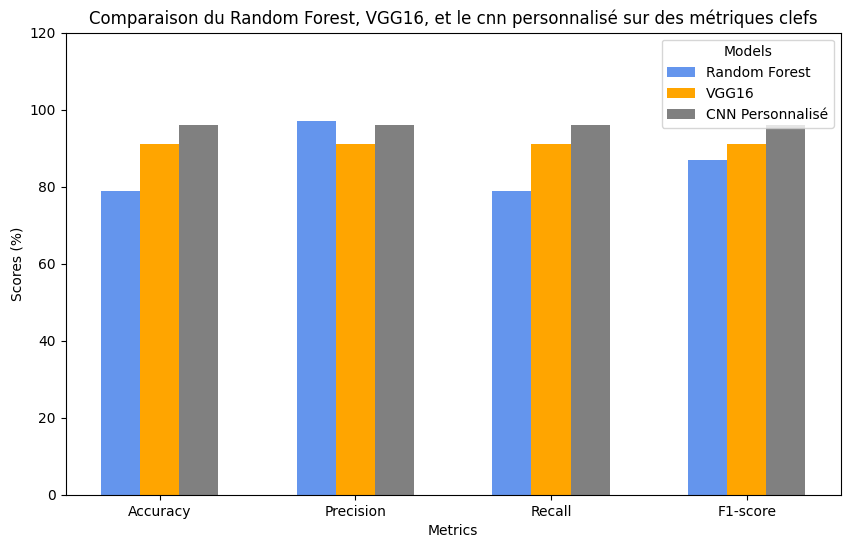

In [42]:
# Models and their values for each metric in percentage
models = ["Random Forest", "VGG16", "Custom CNN"]
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

# Manually input the values for each model as they were executed at different times
values = {
    "Accuracy": [79, 91, 96],
    "Precision": [97, 91, 96],
    "Recall": [79, 91, 96],
    "F1-score": [87, 91, 96]
}

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['cornflowerblue', 'orange', 'gray']
for i, model in enumerate(models):
    metric_values = [values[metric][i] for metric in metrics]
    ax.bar(x + i * width, metric_values, width, label=model, color=colors[i])

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores (%)")
ax.set_title("Comparison of Random Forest, VGG16, and Custom CNN on Key Metrics")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 120)
ax.legend(title="Models", loc="upper right")

plt.show()



The results clearly highlight a strong trend in favor of the custom CNN, which outperforms all other models across key metrics, achieving well-balanced and high performance. VGG16 follows closely with good scores, though slightly lower, while the Random Forest, although effective in certain scenarios, exhibits overall weaker performance.

In terms of **precision**, the Random Forest stands out with a score of 97%, the highest among the models. This performance indicates that when it predicts a class, it is almost always correct, minimizing false positives. However, this strength in precision is offset by significantly lower recall scores, suggesting that it fails to capture all positive cases.

# 4 CONCLUSION

The three models tested (Random Forest, fine-tuned VGG16, and custom CNN) exhibit varying performance levels in classifying white blood cell images. While the Random Forest demonstrates notably high precision (97%), it suffers from significant limitations in recall (79%), suggesting its inability to capture the full complexity of the different classes, particularly for visually similar types such as monocytes and neutrophils. Additionally, the fine-tuned VGG16 model offers balanced performance (91% across all metrics) but falls short of the custom CNN, which can be attributed to an architecture less specifically tailored to the task.

The custom CNN stands out with excellent performance across all metrics, achieving consistently high scores (96% for accuracy, precision, recall, and F1-score). This performance underscores its ability to effectively extract complex features from the images, even for the most challenging classes, such as eosinophils and neutrophils.

In conclusion, this project highlights that, among the evaluated models, the custom CNN is the most suitable for white blood cell classification. It not only provides superior overall accuracy but also demonstrates an enhanced capacity to generalize and capture class diversity, making it particularly relevant for medical applications.

To enhance model performance, an ensemble learning approach could be employed by combining the predictions of the different models (RF, VGG16, and custom CNN) to leverage the strengths of each and produce more robust predictions. Further fine-tuning of the VGG16 model on deeper layers, with a reduced learning rate, could refine its classification capabilities, particularly for more complex classes such as eosinophils and neutrophils. Additionally, applying resampling techniques, such as increasing the representation of minority classes, could strengthen prediction balance and improve recall scores for less well-identified classes.